# Comparing DEMs and GCPs - Tweed Heads
The workflow below doesn't consider spatial mis-alignment.

In [1]:
import geopandas as gpd
import numpy as np
import rioxarray
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [2]:
gcp_file = "/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/Data Exploration/Ground Control/NSW/tweed_heads_scims_marks_filtered.gpkg"

In [3]:
gcps = gpd.read_file(gcp_file)
len(gcps)

25

In [4]:
# Load DSM raster using xarray
ds_7cm = rioxarray.open_rasterio("/Users/Fangyuan/Documents/Projects/AGO/Elevation/Tweed_Heads/DEM_DSM_DTM/Source Elevation Data/AUS_GoldCoast_2021_DSM/dsm/tweekheads-dsm-8cm.vrt")  # Replace with your DSM file path
#ds_28cm = rioxarray.open_rasterio(dem_28cm_file)  # Replace with your DSM file path

gcps = gcps.to_crs(ds_7cm.rio.crs)
# Extract GCP coordinates
gcps_x = gcps.geometry.x
gcps_y = gcps.geometry.y
# Extract raster values at GCP locations
gcps["DSM_7cm"] = [ds_7cm.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_x, gcps_y)]
#gcps["DSM_28cm"] = [ds_28cm.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_x, gcps_y)]

In [5]:
%%script echo skipping cell
# AGO 1m 
dem_1m_file = "/Users/Fangyuan/Documents/Projects/AGO/Elevation/Launceston/AGO/DEM_DSM_DTM/Source Elevation Data/AUS_Tasmania_2008-19_DEM/z55/GDA94/Tamar2008_DEM_1m.vrt"
dem_1m = rioxarray.open_rasterio(dem_1m_file)
gcps_1m = gcps.to_crs(dem_1m.rio.crs)
# Extract GCP coordinates
gcps["DEM_1m"] = [dem_1m.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_1m.geometry.x, gcps_1m.geometry.y)]

skipping cell


In [6]:
# NSW 1m - 2020 - "GDA2020 / MGA zone 55" ("EPSG:7855")
nsw_1m_path = "/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/Data Exploration/Tweed Heads DEM/NSW_2020_DEM_1m.vrt"
nsw_1m = rioxarray.open_rasterio(nsw_1m_path)
gcps_ga = gcps.to_crs(nsw_1m.rio.crs)
# Extract GCP coordinates
gcps["DEM_GA_1m"] = [nsw_1m.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_ga.geometry.x, gcps_ga.geometry.y)]


In [7]:
gcps.head()

,OBJECTID,marktype,marknumber,markstatus,monumenttype,markalias,trigname,trigtype,monumentlocation,mgazone,...,gdaheight_label,gdaposuncertainty_label,gdalocuncertainty_label,ahdposuncertainty_label,ahdlocuncertainty_label,gdaheightposuncertainty_label,gdaheightlocuncertainty_label,geometry,DSM_7cm,DEM_GA_1m
0,9846,SS,145528,F,BRASS PLAQUE,None,None,None,G,56,...,43.47,0.02,0.03,,,0.03,0.04,POINT Z (556412.896 6872632.727 0),4.091094,4.000000
1,12347,SS,76771,F,SSM IN CONC,None,None,None,G,56,...,128.57,0.02,0.03,0.05,0.01,0.03,0.04,POINT Z (549307.259 6876601.79 0),89.107536,88.931000
2,17904,SS,99689,F,BRASS PLAQUE,None,None,None,G,56,...,50.20,0.02,0.04,,,0.03,0.04,POINT Z (556126.94 6869189.831 0),10.852322,1.055000
3,25803,SS,145506,F,BRASS PLAQUE,None,None,None,G,56,...,49.25,0.02,0.03,,,0.03,0.04,POINT Z (556884.542 6872570.845 0),9.967772,24.191000
4,29336,GB,1832,F,DEEP DRIVEN ROD,TS 6679-5,None,None,G,56,...,94.99,0.03,0.04,0.01,0.01,0.07,0.07,POINT Z (538028.404 6865885.244 0),0.000000,66.581001


In [8]:
def compare_cols(col1, col2):
    # Compute offset (difference)
    offset = gcps[col1] - gcps[col2]
    # Compute IQR (Interquartile Range) for Outlier Removal
    Q1 = offset.quantile(0.25)
    Q3 = offset.quantile(0.75)
    IQR = Q3 - Q1
    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    keep = (offset >=lower_bound) & (offset <=upper_bound)

    print(f"{len(offset) - keep.sum()} outliers removed from {len(offset)} pairs")

    mean_offset = np.mean(offset[keep])
    std_offset = np.std(offset[keep])

    # Compute RMSE
    rmse = np.sqrt(np.mean((offset[keep]-mean_offset)** 2))

    # Compute MAE
    mae = np.mean(np.abs((offset[keep]-mean_offset)))

    # Compute correlation
    cor, p_value = pearsonr(gcps[col1][keep], gcps[col2][keep])

    print(f"Correlation Between {col1} and {col2}: {cor:.3f}")
    print(f"offset mean and std: {mean_offset:.3f}, {std_offset:.3f}")
    print(f"rmse: {rmse:.3f}, mae: {mae:.3f}")

    # Plot scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=gcps[col1][keep], y=gcps[col2][keep], scatter_kws={'s': 10}, line_kws={"color": "red"})

    # Add labels and title
    plt.xlabel(f"{col1}")
    plt.ylabel(f"{col2}")
    plt.title(f"Correlation Between {col1} and {col2}(r={cor:.3f})");

8 outliers removed from 25 pairs
Correlation Between ahdheight_label and DEM_GA_1m: 1.000
offset mean and std: -0.049, 0.115
rmse: 0.115, mae: 0.097


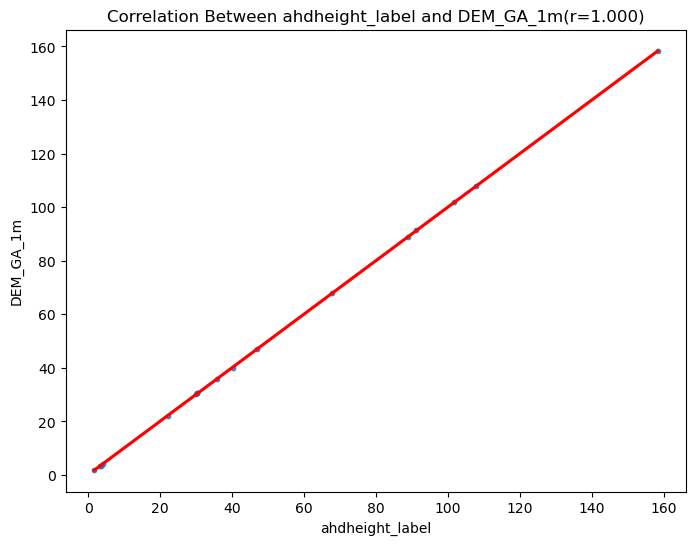

In [9]:
# NSW 1m DEM
compare_cols("ahdheight_label", "DEM_GA_1m")

7 outliers removed from 25 pairs
Correlation Between ahdheight_label and DSM_7cm: 1.000
offset mean and std: -0.025, 0.129
rmse: 0.129, mae: 0.107


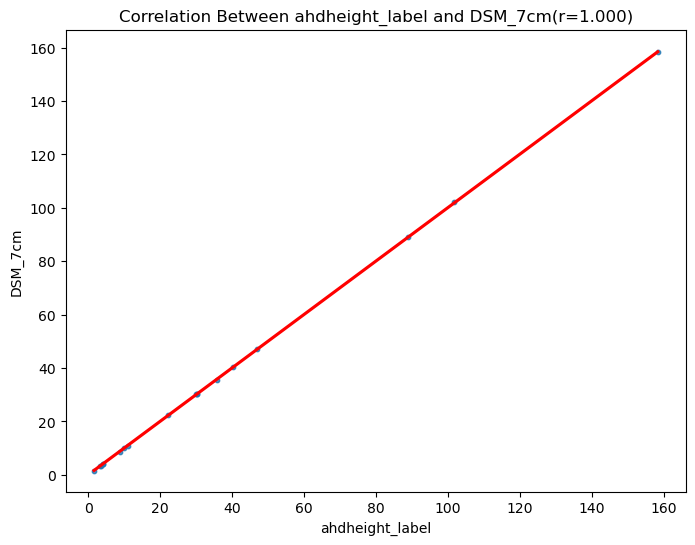

In [10]:
# AGO 7cm
compare_cols("ahdheight_label", "DSM_7cm")